In [2]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Variational circuits

Variational circuits, or parametrized quantum circuits (PQCs), refer to a set of quantum circuits that depend on parameters. PQCs play an important role in most of the near-term quantum machine learning algorithms, such as quantum neural networks (for details, refer to the Quantum neural network unit). Parameterized quantum circuits usually involve one or many data encoding layers and one or many parametric circuit layers, which are collectively referred to as **variational circuits**. 

After the quantum state is prepared from a feature map, the next step is to extract the expectation value of a certain local observable from the wavefunction built from the variational quantum circuit. The expectation value can be thought of as a parameter-dependent loss function designed for a particular task. The parameters of the quantum circuits are optimized iteratively on a classical computer until the loss function converges to its lowest value. 

Variational circuits have increased in popularity because of their usefulness for near-tearm quantum devices. Without error correction techniques, the near-term quantum devices are limited in their capacity to run large-depth circuits because the qubits are susceptible to noise. Variational circuits are used to learn the parameters of short-depth circuits composed of parametric gates in order to achieve a certain computational task without the added machinery of error correction.  

This idea is captured in the following formula: 

$$|\Psi(\theta, \phi)\rangle = W(\theta)U(\phi(X))|0\rangle^{\otimes n} = \mathcal{U}(\theta, \phi)|0\rangle^{\otimes n},$$

where $U(\phi(X))$ is a unitary that embeds the data vector (*data encoding circuit blocks*), and $W(\theta)$ corresponds to the circuit-containing parameters that vary with every iteration of the training process (*trainable circuit blocks*). The variational part of the parameterized quantum circuits is known by various names: ansatz, variational form, variational circuit, and circuit templates.

The [Qiskit](https://github.com/Qiskit) library provides functions to build custom variational circuits as well as a set of pre-built templates for various tasks. We will next explain how to use these functions to build a custom variational circuit, and then will provide a list of built-in trainable circuit templates, such as `RealAmplitudes`, `EfficientSU2`, and so on. 

## Constructing a parametrized quantum circuit 

 In this section, we show how to build a template using basic building blocks from Qiskit.

In [3]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import Parameter

In [4]:
# Parameters are initialized with a string indicator
parameter_0 = Parameter('α')
parameter_1 = Parameter('β')

# We can now pass the initialized parameters at rotation angle arguments
circuit = QuantumCircuit(1)
circuit.ry(theta=parameter_0, qubit=0)
circuit.rx(theta=parameter_1, qubit=0)
circuit.draw('mpl')

This is one of the simplest variational circuits, composed of two single-qubit rotation gates. Next, we will see how to build a more interesting example of a variational circuit with multiple single-qubit and multi-qubit gates.

In [5]:
from qiskit.circuit import ParameterVector

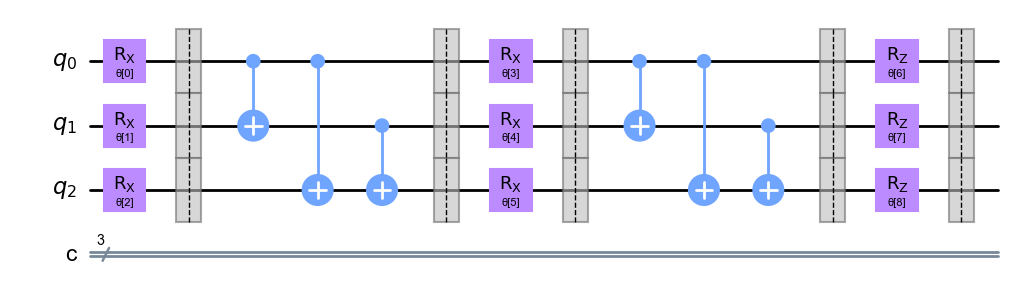

In [6]:
n_qubits = 3
n_layers = 2

# Parameters are initialized with a string indicator and integer indicating the vector length
parameters = ParameterVector('θ', n_qubits*(n_layers+1))

circuit = QuantumCircuit(n_qubits, n_qubits)
for layer in range(n_layers):
    for i in range(n_qubits):
        circuit.rx(parameters[n_qubits*layer+i], i)
    circuit.barrier()

    # Appending entangling CNOT gates
    for i in range(n_qubits):
        for j in range(i):
            circuit.cx(j, i)
    circuit.barrier()
    
# Appending a layer of Rz gates
for i in range(n_qubits):
    circuit.rz(parameters[n_qubits*n_layers+i], i)
circuit.barrier()

circuit.draw('mpl')

In [7]:
# Parameters of the variational circuits can be accessed
list(circuit.parameters)

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5]),
 ParameterVectorElement(θ[6]),
 ParameterVectorElement(θ[7]),
 ParameterVectorElement(θ[8])]

### Assign values to parameters

Assign numerical values to the variational circuits with either `assign_parameters` or `bind_parameters`.

In [8]:
param_dict = {parameter: np.random.random() for parameter in parameters}
param_dict

{ParameterVectorElement(θ[0]): 0.784616449305986,
 ParameterVectorElement(θ[1]): 0.4415889260900525,
 ParameterVectorElement(θ[2]): 0.7065785282080804,
 ParameterVectorElement(θ[3]): 0.5959978449971091,
 ParameterVectorElement(θ[4]): 0.9742906488933171,
 ParameterVectorElement(θ[5]): 0.1999097977145352,
 ParameterVectorElement(θ[6]): 0.1473166580234031,
 ParameterVectorElement(θ[7]): 0.9763697333247999,
 ParameterVectorElement(θ[8]): 0.08228254065119955}

In [9]:
new_circuit = circuit.assign_parameters(parameters=param_dict)
new_circuit.draw('mpl')

In [10]:
from qiskit.visualization import plot_state_city

In [11]:
backend = Aer.get_backend('statevector_simulator')
result = backend.run(new_circuit).result()
statevector = result.get_statevector()
plot_state_city(statevector)

## PQC in Qiskit

In this section we show a few examples of built-in variational circuit templates available in Qiskit.

In [12]:
from qiskit.circuit.library import (EfficientSU2, ExcitationPreserving, 
                                    PauliTwoDesign, RealAmplitudes)

The ``EfficientSU2`` circuit consists of layers of single-qubit operations spanned by $SU(2)$ and $CX$ entanglements. This is a heuristic pattern that can be used to prepare trial wavefunctions for variational quantum algorithms or classification circuits for machine learning.

In [13]:
EfficientSU2(3, reps=1).decompose().draw('mpl')

The ``ExcitationPreserving`` circuit (which is mostly relevant for material science and quantum chemistry applications) preserves the ratio of $|00\rangle$, $|01\rangle + |10\rangle$, and $|11\rangle$ states. 

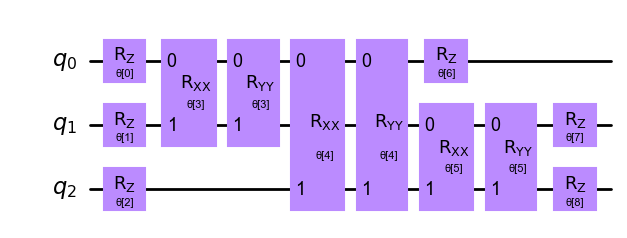

In [14]:
ExcitationPreserving(3, reps=1).decompose().draw('mpl')

`PauliTwoDesign`: This class implements a particular form of a 2-design circuit, which is frequently studied in quantum machine learning literature, such as investigating Barren plateaus in variational algorithms.

In [15]:
PauliTwoDesign(3, reps=1).decompose().draw('mpl')       

The ``RealAmplitudes`` circuit is a heuristic trial wave function used as ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of of alternating layers of $Y$ rotations and $CX$ entanglements. The entanglement pattern can be user-defined or selected from a predefined set. It is called ``RealAmplitudes`` since the prepared quantum states will only have real amplitudes; the complex part is always 0.

In [16]:
RealAmplitudes(3, reps=1).decompose().draw('mpl')

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>
